In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

%matplotlib inline
sns.set(style='whitegrid')
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
def drop_columns(data):
    return data.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

data = yf.Ticker('MSFT')
df = drop_columns(data.history(start='2010-01-01'))
df.head()

,Close
Date,
2010-01-04,24.168472
2010-01-05,24.176279
2010-01-06,24.027906
2010-01-07,23.778025
2010-01-08,23.942017


In [3]:
samples = np.arange(0, len(df), 1)
values = df['Close'].to_numpy()
values.shape, samples.shape

((2712,), (2712,))

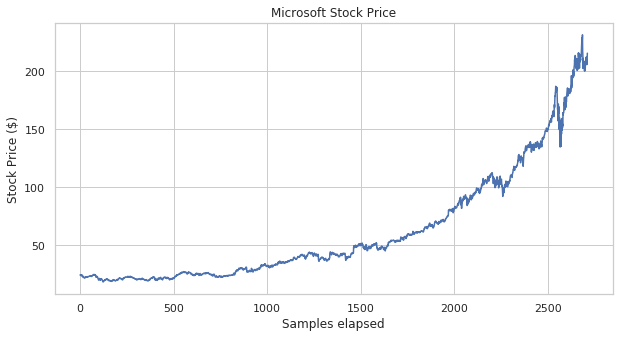

In [4]:
plt.figure(figsize=(10,5))
plt.title('Microsoft Stock Price')
plt.plot(samples, values)
plt.xlabel('Samples elapsed')
plt.ylabel('Stock Price ($)')
plt.show()

In [5]:
df = pd.DataFrame(dict(price=values), index=samples, columns=['price'])

train_size = int(len(df)*0.7)
val_size = int(len(df)*0.2)
test_size = int(len(df)*0.1)

val_set = train_size + val_size
test_size = train_size + val_size + test_size
train, val, test = df.iloc[0:train_size], df.iloc[train_size:val_set], df.iloc[val_set:len(df)]
len(train), len(val), len(test)

(1898, 542, 272)

In [6]:
TIME_STEPS = 10

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train, train.price, TIME_STEPS)
X_val, y_val = create_dataset(val, val.price, TIME_STEPS)
X_test, y_test = create_dataset(test, test.price, TIME_STEPS)

X_train.shape, y_train.shape

((1888, 10, 1), (1888,))

In [7]:
def generate_model():
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.LSTM(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

model = generate_model()
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    verbose=1,
    shuffle=False
)

Train on 1888 samples
Epoch 1/50
1888/1888 [==============================] - 4s 2ms/sample - loss: 34.7312
Epoch 2/50
1888/1888 [==============================] - 1s 604us/sample - loss: 3.4353
Epoch 3/50
1888/1888 [==============================] - 1s 651us/sample - loss: 4.3074
Epoch 4/50
1888/1888 [==============================] - 1s 566us/sample - loss: 2.7330
Epoch 5/50
1888/1888 [==============================] - 1s 676us/sample - loss: 2.7631
Epoch 6/50
1888/1888 [==============================] - 1s 552us/sample - loss: 2.7290
Epoch 7/50
1888/1888 [==============================] - 1s 537us/sample - loss: 2.8885
Epoch 8/50
1888/1888 [==============================] - 1s 558us/sample - loss: 2.8562
Epoch 9/50
1888/1888 [==============================] - 1s 635us/sample - loss: 2.6432
Epoch 10/50
1888/1888 [==============================] - 1s 568us/sample - loss: 2.5775
Epoch 11/50
1888/1888 [==============================] - 1s 659us/sample - loss: 2.4668
Epoch 12/50
1888/188

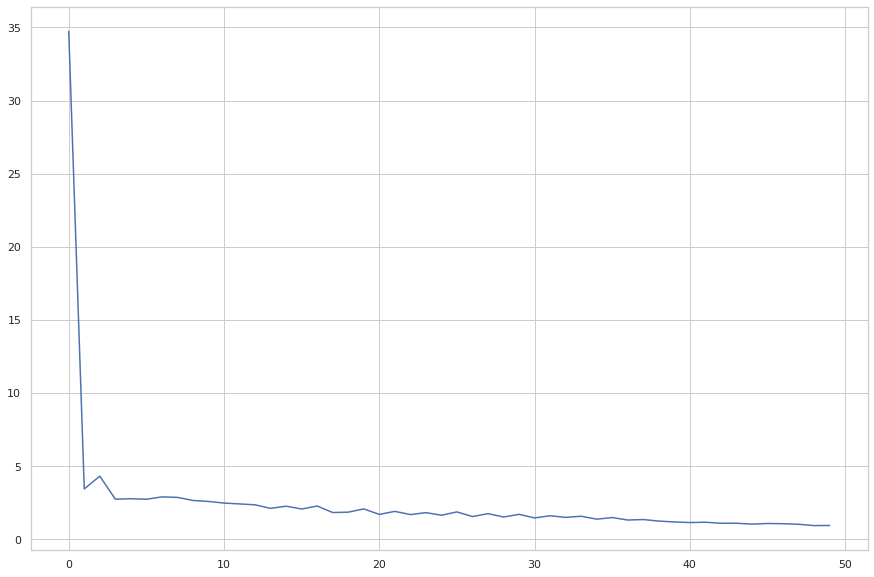

In [8]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.show()

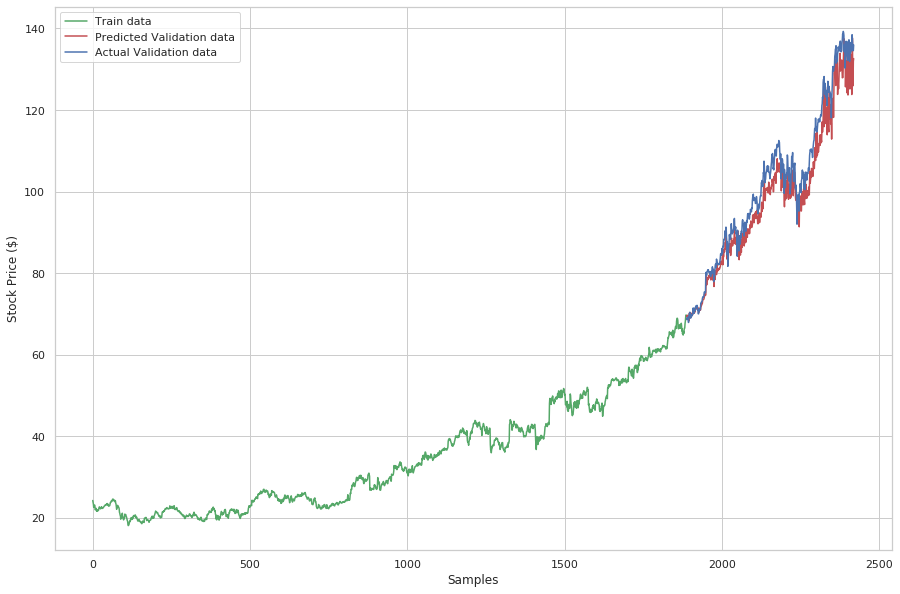

In [9]:
y_pred_val = model.predict(X_val)

plt.figure(figsize=(15,10))
plt.plot(np.arange(0, len(y_train)), y_train, 'g')
plt.plot(np.arange(len(y_train), (len(y_train)+len(y_pred_val))), y_pred_val, 'r')
plt.plot(np.arange(len(y_train), (len(y_train)+len(y_pred_val))), y_val, 'b')
plt.legend(['Train data', 'Predicted Validation data', 'Actual Validation data'])
plt.xlabel('Samples')
plt.ylabel('Stock Price ($)')
plt.savefig('stacked_lstm_v1.png')
plt.show()